In [9]:
from sklearnex import patch_sklearn
patch_sklearn()

import re
import sys
import os

sys.path.append(os.path.abspath(os.path.join("..")))

import pandas as pd
from tqdm import tqdm
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from joblib import Parallel, delayed

from utils import calc_metrics

import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [10]:
X = pd.read_csv('../data/x.csv', index_col='date')
y = pd.read_csv('../data/y.csv', index_col='date').iloc[:, 0]

metrics = pd.read_csv('metrics.csv', index_col=0)

### N-граммы плюс Naive Bayes

Попробуем решить задачу с помощью алгоритма Naive Bayes, подберем оптимальные значения для параметра `ngram_range` и обучим лучшую модель.

In [11]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words('russian'))

def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return text

In [12]:
def _calc_metrics(start, stop):
    vectorizer = CountVectorizer(
        preprocessor=preprocessor,
        ngram_range=(start, stop)
    )
    bow_ngram = vectorizer.fit_transform(X.release)
    return calc_metrics(
        bow_ngram, y,
        MultinomialNB, 
        name='MultinomialNB',
        plot=False
    ), (start, stop)

auc = Parallel(n_jobs=-1)(delayed(
    _calc_metrics
)(start, stop) for start in range(1, 10) for stop in range(start, min(10, start + 4)))

(roc_auc, best_model), (start, stop) = max(auc, key=lambda x: x[0][0])

print(f"Лучшая модель - ngram_range({start}, {stop})")
print(f"ROC-AUC = {roc_auc}")

Лучшая модель - ngram_range(3, 6)
ROC-AUC = 0.7699495394003403


In [13]:
vectorizer = CountVectorizer(
    preprocessor=preprocessor,
    ngram_range=(start, stop)
)

vectorizer.fit(X.release)

bow_ngram = vectorizer.transform(X.release)

              precision    recall  f1-score   support

        -1.0       0.68      0.83      0.75        23
         0.0       0.58      0.42      0.49        26
         1.0       0.62      0.68      0.65        19

    accuracy                           0.63        68
   macro avg       0.63      0.64      0.63        68
weighted avg       0.62      0.63      0.62        68



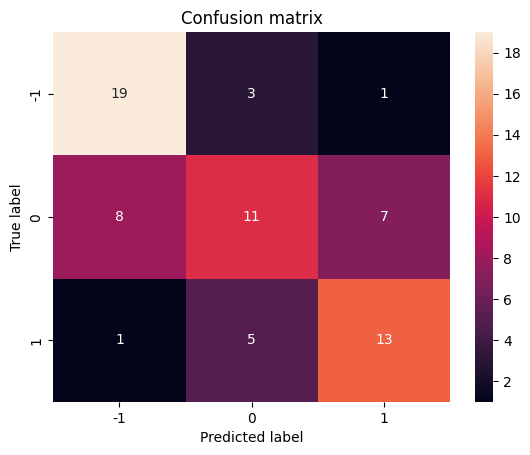

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.617647,0.623226,0.633465,0.617174,0.764882,0.770478
bow elasticnet,0.602941,0.606085,0.617424,0.599630,0.779381,0.783093
bow release title,0.573529,0.579365,0.591162,0.572317,0.782876,0.786569
bow release all num,0.573529,0.579365,0.591162,0.572317,0.776894,0.781362
bow svc only release,0.632353,0.641077,0.650132,0.634718,0.784936,0.790207
tf_idf l1 only release,0.617647,0.617077,0.625831,0.615795,0.784421,0.789606
tf_idf only release best word,0.720588,0.722979,0.737452,0.716658,0.808578,0.813516
tf_idf title release,0.705882,0.710449,0.727536,0.702165,0.811914,0.816596
tf_idf numerical release,0.632353,0.636409,0.687037,0.621927,0.774436,0.776844


In [14]:
metric, model = calc_metrics(bow_ngram, y, MultinomialNB, name='MultinomialNB')
metrics = pd.concat((metrics, metric))
metrics

Получили качество чуть лучше чем минимальный безлайн.

In [15]:
metrics.to_csv('metrics.csv')